In [1]:
## General librairies
import pandas as pd
import numpy as np
import _pickle as pickle
import matplotlib.pyplot as plt
import random
import sys
import time
from copy import deepcopy
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import cohen_kappa_score
import optuna
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import json

import dateutil.parser

Using TensorFlow backend.


In [2]:
specs = 'specs.csv'
test = 'test.csv'
train = 'train.csv'
train_labels = 'train_labels.csv'
subs = 'sample_submission_exemple.csv'

In [3]:
df = pd.read_csv(train)

In [4]:
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def relative_time(x):
    x1 = []
    for elt in x:
        x1.append((elt-x[0]).item()/1000000000)
    return x1

def categorise(x):
    dico = {}
    count = 0
    for elt in x:
        if not(elt in dico):
            dico[elt] = count
            count += 1
    return dico

def padding( dataset, n):
    d = list(np.zeros(len(dataset)))
    c = 0
    count = 0
    for elt in dataset:
        
        if count % 100 == 0:
            print(count)
        u = elt.shape[0]
        
        if u<200:
            c += 1
        
        if u > n:
            d[count] = elt[-n:]
        else:
            a = np.zeros(((n-u), elt.shape[1])) -1
            elt = np.concatenate([a, elt], axis = 0)
            d[count] = elt
        count += 1
    return d

def build_line(df, installation_id, game_session):
    
    df1 = df[(df['installation_id']==installation_id)&(df['date']<=df[(df['installation_id']==installation_id)&(df['game_session']==game_session)]['date'].iloc[0])]
    dico = categorise(df1['game_session'].unique())
    df1 = df1.replace({'game_session' : dico})
    x = relative_time(df1['date'].values)
    
    df1['time_delta'] = x
    
#     df1 = df1.drop_duplicates(subset = ['event_id'])
    
    cats_to_keep = ['game_session','time_delta','title','type', 'world',  'event_count', 'game_time', 'event_code']
    df1 = df1[cats_to_keep]
    return df1

def format_input(X):
    return [X[:,:,4:24], X[:,:,0].reshape((X.shape[0], X.shape[1],1)), 
            X[:,:,1].reshape((X.shape[0], X.shape[1],1)), 
            X[:,:,2].reshape((X.shape[0], X.shape[1],1)),
            X[:,:,3].reshape((X.shape[0], X.shape[1],1)),
            X[:,:,24].reshape((X.shape[0], X.shape[1],1))]

def build_feature(i,session):
    vect = []
    
    title = session.iloc[0]['title']
    typ = session.iloc[0]['type']
    
    vect.append(session.iloc[0]['game_session'])    ##game_session
    vect.append(session.iloc[0]['installation_id'])   ##installation_id
    vect.append(session.iloc[0]['title'])  ##title
    vect.append(session.iloc[0]['type'])  ##type
    vect.append(session.iloc[0]['world'])  ##world
    vect.append(session.iloc[0]['timestamp'])  ##timestamp
    
    
    ## adding validation data if game or assessment
    if typ == 'Game' or typ == 'Assessment':
        pos = 0
        neg = 0
        for elt in session[session['event_code']==4100]['event_data']:
            a = json.loads(elt)['correct']
#             print(a)
            if a:
                pos+=1
            else:
                neg+=1
            
        if pos+neg ==0:
            acc = -1
        else:
            acc = pos/(pos+neg)
        
#         print(acc)
        if acc == 1:
            acc_class = 3
        elif acc == 0.5:
            acc_class = 2
        elif acc <=0:
            acc_class = 0
        else:
            acc_class = 1
#         print(acc_class)
        vect.append(acc_class)   ## accuracy_group
        vect.append(acc)       ## accuracy
        vect.append(pos)       ## n_positive
        vect.append(neg)       ## n_negative
            
            
    else: 
        vect.append(-1)  ##accuracy_group
        vect.append(-1) ## accuracy_group
        vect.append(-1)  ## n_positive
        vect.append(-1)  ## n_negative
    
    ## Adding features relative to Game, Assessment and activity
    if typ != 'Clip':
        ## Avg time per instruction
        
        st = session['game_time'][session['event_code'] == 3010]
        en = session['game_time'][session['event_code'] == 3110]
        
        s = min(st.shape[0], en.shape[0])
        if s!=0:
            vect.append((en[:s].sum()-st[:s].sum())/s)  ## time per instruction
        else:
            vect.append(-1)  ##time per instruction
        
        ##total_time
        total_time = session['game_time'].max()/1000
        vect.append(total_time)
        
        ##number of actions
        n_action = session[(session['event_code']>=4020)&(session['event_code']<=4080)].shape[0]
        vect.append(n_action)
        
        ## rounds
        n_rounds_st = session[session['event_code']==2020].shape[0]
        n_rounds_en = session[session['event_code']==2030].shape[0]
        
        vect.append(n_rounds_st)
        vect.append(n_rounds_st)
        
        if n_rounds_st != 0:
            vect.append(n_action/n_rounds_st)
            vect.append(total_time/n_rounds_st)
        else:
            vect.append(-1)
            vect.append(-1)
        ## hints
        vect.append(session[session['event_code']==4090].shape[0])
        
    else:
        vect.append(-1)  ## time per instruction
        vect.append(-1)  ##  total time
        vect.append(-1)  ## n_actions
        vect.append(-1)  ## n_rounds_start
        vect.append(-1)  ## n_round end
        vect.append(-1)  ## action per round
        vect.append(-1)  ## time per round
        vect.append(-1)  ## N_hints
    
    if typ == 'Game' or typ == 'Assessment':
        ## feed backs
        
        n_correct_f = session[session['event_code'] == 3121].shape[0]
        n_incorrect_f = session[session['event_code'] == 3120].shape[0]
        
        vect.append(n_correct_f)
        vect.append(n_incorrect_f)
        
        if n_incorrect_f + n_correct_f != 0:
            vect.append(n_correct_f/(n_correct_f+n_incorrect_f))
        else:
            vect.append(0)
        
        if n_correct_f !=0:
            vect.append((session['game_time'][session['event_code'] == 3121].sum()-session['game_time'][session['event_code'] == 3021].sum())/n_correct_f)
        else:
            vect.append(-1)
        
        if n_incorrect_f !=0:
            vect.append((session['game_time'][session['event_code'] == 3120].sum()-session['game_time'][session['event_code'] == 3020].sum())/n_correct_f)
        else:
            vect.append(-1)
    else:
        vect.append(-1)  ## correct_feed
        vect.append(-1)  ## incorrect_feed
        vect.append(-1)  ## acc_feed
        vect.append(-1)  ## time correct feedback
        vect.append(-1)  ## time incorrect feedback
    
    if typ == 'Game':
        vect.append(session[session['event_code'] == 2080].shape[0])
        vect.append(session[session['event_code'] == 2081].shape[0])
        vect.append(session[session['event_code'] == 2060].shape[0])
        vect.append(session[session['event_code'] == 2075].shape[0])
        
        
    else:
        vect.append(-1)  ## n movie
        vect.append(-1)  ## n_skipp movie
        vect.append(-1)  ## tutorial
        vect.append(-1)  ## skipped tutorial
        
    
    
    return vect

titles = df['title'].unique()
def build_set(df, installation_id, game_session):
    df1 = df[df['installation_id']==installation_id]
    
    df1 = df1.sort_values(by = ['date'], ascending = True)
    date = df1[df1['game_session']==game_session].iloc[0]['date']
    pred_title = df1[df1['game_session']==game_session].iloc[0]['title']
    
    df1['pred_title'] = pred_title
    df1 = df1[df1['date'] < date]
    
    
    vect = []
    
    vect.append(pred_title)
    
    ## Clip
    df2 = df1[df1['type']=='Clip']
    vect.append(df2.shape[0])
    
    ## Activity
    df2 = df1[df1['type']=='Activity']
    
    #n_activity
    vect.append(df2.shape[0])
    # instruction
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())
    
    ## Assessment
    df2 = df1[df1['type']=='Assessment']
    if pred_title in df2['title'].values:
        vect.append(1)
    else:
        vect.append(0)
    vect.append(df2.shape[0])
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').mean())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').mean())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').mean())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').mean())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').mean())
    
    ## Games
    df2 = df1[df1['type']=='Game']
    vect.append(df2.shape[0])
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').mean())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').mean())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').mean())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').mean())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').mean())
    vect.append(df2[df2['movies']!=-1]['movies'].values.astype('float32').sum())
    vect.append(df2[df2['skipped_movie']!=-1]['skipped_movie'].values.astype('float32').sum())
    vect.append(df2[df2['tuto']!=-1]['tuto'].values.astype('float32').sum())
    vect.append(df2[df2['skipped_tuto']!=-1]['skipped_tuto'].values.astype('float32').mean())
    
    ## Activity done
    for x in titles:
        vect.append( df1[df1['title']==x].shape[0])
    
    
    return vect

columns = [
    'game_session',
'installation_id',
'title',
'type',
'world',
'timestamp',
'accuracy_group',
'accuracy',
'n_positive',
'n_negative',
'time_instruction',
'actions',
'total_time',
'start_rounds',
'end_rounds',
'action_rounds',
'time_rounds',
'hints',
'correct_feed',
'incorrect_feed',
'acc_feed',
'time_corr_feed',
'time_inc_feed',
'movies',
'skipped_movie',
'tuto',
'skipped_tuto'
]

cols = [
    'pred_title',
'n_clip',
'n_activity',
'Activity_time_instruction',
'Activity_total_time',
'Activity_actions',
'Activity_start_rounds',
'Activity_end_rounds',
'Activity_action_rounds',
'Activity_time_rounds',
'Activity_hints',
'same_title',
'n_assessment',
'Assessment_accuracy_group',
'Assessment_time_instruction',
'Assessment_total_time',
'Assessment_actions',
'Assessment_start_rounds',
'Assessment_end_rounds',
'Assessment_action_rounds',
'Assessment_time_rounds',
'Assessment_hints',
'Assessment_correct_feed',
'Assessment_incorrect_feed',
'Assessment_time_corr_feed',
'Assessment_time_inc_feed',
'Assessment_acc_feed',
'Assessment_accuracy',
'Assessment_n_positive',
'Assessment_n_negative',
'n_games',
'Games_accuracy_group',
'Games_time_instruction',
'Games_total_time',
'Games_actions',
'Games_start_rounds',
'Games_end_rounds',
'Games_action_rounds',
'Games_time_rounds',
'Games_hints',
'Games_correct_feed',
'Games_incorrect_feed',
'Games_time_corr_feed',
'Games_time_inc_feed',
'Games_acc_feed',
'Games_accuracy',
'Games_n_positive',
'Games_n_negative',
'Games_movies',
'Games_skipped_movie',
'Games_tuto',
'Games_skipped_tuto',  
]

for elt in titles:
    cols.append('actitivity_title_'+str(elt))

#### Loading Data and grouping by game session

#### Train

In [ ]:
df = pd.read_csv(train)
labels = pd.read_csv(train_labels)
vect = df['event_code']
vect[df['event_id'] == '17113b36'] = 4100
df['event_code'] = vect

dataset = list(np.zeros(df['game_session'].unique().shape[0]))

print(df['game_session'].unique().shape[0])

count = 0
for i, session in df.groupby(['game_session']):
#     if count >= 100:
#         break
    line =build_feature(i, session)
#     dataset.append(line)
    dataset[count] = line
    if count % 1000 == 0:
        print(count)
    count += 1

dataset = np.array(dataset)

data = pd.DataFrame(dataset, columns = columns)

save(data, 'data by session')

#### Test

In [ ]:
df = pd.read_csv(test)
vect = df['event_code']
vect[df['event_id'] == '17113b36'] = 4100
df['event_code'] = vect

dataset = list(np.zeros(df['game_session'].unique().shape[0]))

print(df['game_session'].unique().shape[0])

count = 0
for i, session in df.groupby(['game_session']):
#     if count >= 100:
#         break
    line =build_feature(i, session)
#     dataset.append(line)
    dataset[count] = line
    if count % 1000 == 0:
        print(count)
    count += 1

dataset = np.array(dataset)

data = pd.DataFrame(dataset, columns = columns)

save(data, 'data test by session')

#### Getting test labels

In [ ]:
df = load('data by session')
labels = pd.read_csv(train_labels)

ids = df[df['type']=='Assessment']['installation_id'].unique()
df = df[df.installation_id.isin(ids)]
df = df[df.installation_id.isin(labels.installation_id.unique())]

# dtitle = categorise(df['title'])

# df = df.replace({'title' : dtitle})

# save(dtitle, 'dico_title')

df['date'] = df['timestamp'].apply(dateutil.parser.parse)

df = df.sort_values(by = ['date'], ascending =True)

save(df, 'data by session')

In [ ]:
df = load('data test by session')

ids = df[df['type']=='Assessment']['installation_id'].unique()

# dtitle =load('dico_title')

# df = df.replace({'title' : dtitle})

df['date'] = df['timestamp'].apply(dateutil.parser.parse)

df = df.sort_values(by = ['date'], ascending =True)

game_inst = []
for elt in ids:
    df1 = df[df['installation_id']==elt]
    df1 = df1.sort_values(by = ['date'], ascending = True)
    game_inst.append(df1.iloc[-1]['game_session'])
    
save((ids, game_inst), 'test_labels')
save(df, 'data test by session')

#### Adding test session into train

In [ ]:
df = pd.read_csv(test)

test_train = []

df_labels = df[(df['type'] == 'Assessment')&(df['event_code'] == 4100)][['installation_id', 'game_session']].drop_duplicates(subset = ['installation_id', 'game_session'])

df = load('data test by session')

vect = []
vect1 = []
for i in range(df_labels.shape[0]):
    vect.append(df[(df['installation_id'] == df_labels.iloc[i]['installation_id'])&(df['game_session'] == df_labels.iloc[i]['game_session'])]['accuracy_group'].values[0])
    vect1.append(df[(df['installation_id'] == df_labels.iloc[i]['installation_id'])&(df['game_session'] == df_labels.iloc[i]['game_session'])]['accuracy'].values[0])
    
    
    
df_labels['accuracy_group'] = vect
df_labels['accuracy'] = vect1

save(df_labels, 'test labels')

#### Building train dataset


In [ ]:
clips = ['Welcome to Lost Lagoon!', 'Magma Peak - Level 1',
       'Magma Peak - Level 2', 'Crystal Caves - Level 1',
       'Crystal Caves - Level 2', 'Crystal Caves - Level 3',
       'Tree Top City - Level 1', 'Tree Top City - Level 2',
       'Tree Top City - Level 3', 'Slop Problem',
       'Heavy, Heavier, Heaviest', 'Lifting Heavy Things',
       'Ordering Spheres', '12 Monkeys', 'Balancing Act', 'Costume Box',
       "Pirate's Tale", 'Honey Cake', 'Treasure Map', 'Rulers']

activities = ['Sandcastle Builder (Activity)', 'Watering Hole (Activity)',
       'Bottle Filler (Activity)', 'Fireworks (Activity)',
       'Flower Waterer (Activity)', 'Egg Dropper (Activity)',
       'Chicken Balancer (Activity)', 'Bug Measurer (Activity)']

games = ['All Star Sorting', 'Chow Time', 'Dino Dive', 'Scrub-A-Dub',
       'Bubble Bath', 'Happy Camel', 'Leaf Leader', 'Pan Balance',
       'Dino Drink', 'Crystals Rule', 'Air Show']

assessments = ['Cart Balancer (Assessment)', 'Chest Sorter (Assessment)',
       'Cauldron Filler (Assessment)', 'Mushroom Sorter (Assessment)',
       'Bird Measurer (Assessment)']

def build_set(df, installation_id, game_session):
    df1 = df[df['installation_id']==installation_id]
    
    df1 = df1.sort_values(by = ['date'], ascending = True)
    date = df1[df1['game_session']==game_session].iloc[0]['date']
    pred_title = df1[df1['game_session']==game_session].iloc[0]['title']
    w =  df1[df1['game_session']==game_session].iloc[0]['world']
#     w =  df1[df1['game_session']==game_session].iloc[0]['world']
    
#     df1['game_session'] = game_session
    df1['pred_title'] = pred_title
    df1 = df1[df1['date'] < date]
#     df1 = df1[df1['world'] == w]
    
    vect = []
    
    vect.append(pred_title)
    
    ## Clip
    df2 = df1[df1['type']=='Clip']
    vect.append(df2.shape[0])
    
    ## Activity
    df2 = df1[df1['type']=='Activity']
    
    #n_activity
    vect.append(df2.shape[0])
    # instruction
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())

    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').std())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').std())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').std())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').std())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').std())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').std())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').std())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').std())    

    ## Assessment
    df2 = df1[df1['type']=='Assessment']
    if pred_title in df2['title'].values:
        vect.append(1)
    else:
        vect.append(0)
        
    vect.append(df2.shape[0])
    
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').mean())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').mean())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').mean())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').mean())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').mean())
    
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').std())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').std())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').std())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').std())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').std())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').std())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').std())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').std())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').std())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').std())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').std())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').std())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').std())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').std())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').std())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').std())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').std())
    
    ## Games
    df2 = df1[df1['type']=='Game']
    vect.append(df2.shape[0])
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').mean())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').mean())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').mean())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').mean())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').mean())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').mean())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').mean())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').mean())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').mean())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').mean())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').mean())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').mean())
    vect.append(df2[df2['movies']!=-1]['movies'].values.astype('float32').sum())
    vect.append(df2[df2['skipped_movie']!=-1]['skipped_movie'].values.astype('float32').sum())
    vect.append(df2[df2['tuto']!=-1]['tuto'].values.astype('float32').sum())
    vect.append(df2[df2['skipped_tuto']!=-1]['skipped_tuto'].values.astype('float32').mean())
    
    vect.append(df2[df2['accuracy_group']!=-1]['accuracy_group'].values.astype('float32').std())
    vect.append(df2[df2['time_instruction']!=-1]['time_instruction'].values.astype('float32').std())
    vect.append(df2[df2['total_time']!=-1]['total_time'].values.astype('float32').std())
    vect.append(df2[df2['actions']!=-1]['actions'].values.astype('float32').std())
    vect.append(df2[df2['start_rounds']!=-1]['start_rounds'].values.astype('float32').std())
    vect.append(df2[df2['end_rounds']!=-1]['end_rounds'].values.astype('float32').std())
    vect.append(df2[df2['action_rounds']!=-1]['action_rounds'].values.astype('float32').std())
    vect.append(df2[df2['time_rounds']!=-1]['time_rounds'].values.astype('float32').std())
    vect.append(df2[df2['hints']!=-1]['hints'].values.astype('float32').std())
    vect.append(df2[df2['correct_feed']!=-1]['correct_feed'].values.astype('float32').std())
    vect.append(df2[df2['incorrect_feed']!=-1]['incorrect_feed'].values.astype('float32').std())
    vect.append(df2[df2['time_corr_feed']!=-1]['time_corr_feed'].values.astype('float32').std())
    vect.append(df2[df2['time_inc_feed']!=-1]['time_inc_feed'].values.astype('float32').std())
    vect.append(df2[df2['acc_feed']!=-1]['acc_feed'].values.astype('float32').std())
    vect.append(df2[df2['accuracy']!=-1]['accuracy'].values.astype('float32').std())
    vect.append(df2[df2['n_positive']!=-1]['n_positive'].values.astype('float32').std())
    vect.append(df2[df2['n_negative']!=-1]['n_negative'].values.astype('float32').std())
    vect.append(df2[df2['movies']!=-1]['movies'].values.astype('float32').std())
    vect.append(df2[df2['skipped_movie']!=-1]['skipped_movie'].values.astype('float32').std())
    vect.append(df2[df2['tuto']!=-1]['tuto'].values.astype('float32').std())
    vect.append(df2[df2['skipped_tuto']!=-1]['skipped_tuto'].values.astype('float32').std())
    
    ## Activity done
    for x in titles:
        vect.append( df1[df1['title']==x].shape[0])
    
    t = df1['title'].unique()
    
    
    df1 = df1.drop_duplicates(subset = ['title'], keep = 'last')
    df1.index = df1['title']

    feats_activity = [ 'time_instruction', 'actions', 'total_time', 'start_rounds',
       'end_rounds',  'hints', 'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
       'end_rounds_std',  'hints_std']
    for elt in activities:
        if elt in t:
            temp = list(df1.loc[elt][feats_activity].values.astype('float64'))
            vect.extend(temp)
        else:
            for i in range(len(feats_activity)):
                vect.append(-1)
    
    feats_assessment = ['accuracy_group', 'accuracy', 'n_positive', 'n_negative',
       'time_instruction', 'actions', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
                        'accuracy_group_std', 'accuracy_std', 'n_positive_std', 'n_negative_std',
       'time_instruction_std', 'actions_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std']
    
    for elt in assessments:
        if elt in t:
            temp = list(df1.loc[elt][feats_assessment].values.astype('float64'))
            vect.extend(temp)
        else:
            for i in range(len(feats_assessment)):
                vect.append(-1)
    
    for elt in games:
        if elt == 'Air Show' or elt == 'Pan Balance':
            feats_games = [
                         'accuracy_group', 'accuracy', 'n_positive', 'n_negative',
                       'time_instruction', 'actions', 'total_time', 'start_rounds',
                       'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
                       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
                       'skipped_tuto' ,  'accuracy_group_std', 'accuracy_std', 'n_positive_std', 'n_negative_std',
                       'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
                       'end_rounds_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
                       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std',
                       'skipped_tuto_std'
                        ]
        else:
            feats_games = [
               'time_instruction', 'actions', 'total_time', 'start_rounds',
               'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
               'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
               'skipped_tuto'   , 'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
                       'end_rounds_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
                       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std',
                       'skipped_tuto_std'
                ]
    
        if elt in t:
            temp = list(df1.loc[elt][feats_games].values.astype('float64'))
            vect.extend(temp)
        else:
            for i in range(len(feats_games)):
                vect.append(-1)
    
    
    return vect


In [ ]:
df = load('data by session')

In [ ]:
df.head()

In [ ]:
df = df.drop_duplicates(subset = ['title'], keep = 'last')
df.index = df['title']


In [ ]:
cols = [
    'pred_title',
'n_clip',
'n_activity',
'Activity_time_instruction',
'Activity_total_time',
'Activity_actions',
'Activity_start_rounds',
'Activity_end_rounds',
'Activity_action_rounds',
'Activity_time_rounds',
'Activity_hints',
    
'Activity_time_instruction_std',
'Activity_total_time_std',
'Activity_actions_std',
'Activity_start_rounds_std',
'Activity_end_rounds_std',
'Activity_action_rounds_std',
'Activity_time_rounds_std',
'Activity_hints_std',    

'same_title',
'n_assessment',
'Assessment accuracy_group',
'Assessment_time_instruction',
'Assessment_total_time',
'Assessment_actions',
'Assessment_start_rounds',
'Assessment_end_rounds',
'Assessment_action_rounds',
'Assessment_time_rounds',
'Assessment_hints',
'Assessment_correct_feed',
'Assessment_incorrect_feed',
'Assessment_time_corr_feed',
'Assessment_time_inc_feed',
'Assessment_acc_feed',
'Assessment_accuracy',
'Assessment_n_positive',
'Assessment_n_negative',

'Assessment accuracy_group_std',
'Assessment_time_instruction_std',
'Assessment_total_time_std',
'Assessment_actions_std',
'Assessment_start_rounds_std',
'Assessment_end_rounds_std',
'Assessment_action_rounds_std',
'Assessment_time_rounds_std',
'Assessment_hints_std',
'Assessment_correct_feed_std',
'Assessment_incorrect_feed_std',
'Assessment_time_corr_feed_std',
'Assessment_time_inc_feed_std',
'Assessment_acc_feed_std',
'Assessment_accuracy_std',
'Assessment_n_positive_std',
'Assessment_n_negative_std',
    
    
'n_games',
'Games accuracy_group',
'Games_time_instruction',
'Games_total_time',
'Games_actions',
'Games_start_rounds',
'Games_end_rounds',
'Games_action_rounds',
'Games_time_rounds',
'Games_hints',
'Games_correct_feed',
'Games_incorrect_feed',
'Games_time_corr_feed',
'Games_time_inc_feed',
'Games_acc_feed',
'Games_accuracy',
'Games_n_positive',
'Games_n_negative',
'Games_movies',
'Games_skipped_movie',
'Games_tuto',
'Games_skipped_tuto',  
    
'Games accuracy_group_std',
'Games_time_instruction_std',
'Games_total_time_std',
'Games_actions_std',
'Games_start_rounds_std',
'Games_end_rounds_std',
'Games_action_rounds_std',
'Games_time_rounds_std',
'Games_hints_std',
'Games_correct_feed_std',
'Games_incorrect_feed_std',
'Games_time_corr_feed_std',
'Games_time_inc_feed_std',
'Games_acc_feed_std',
'Games_accuracy_std',
'Games_n_positive_std',
'Games_n_negative_std',
'Games_movies_std',
'Games_skipped_movie_std',
'Games_tuto_std',
'Games_skipped_tuto_std',  
]

for elt in titles:
    cols.append('actitivity_title_'+str(elt))


feats_activity = [ 'time_instruction', 'actions', 'total_time', 'start_rounds',
       'end_rounds',  'hints', 'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
       'end_rounds_std',  'hints_std']
for elt in activities:
    for elt1 in feats_activity:
        cols.append(elt + "_" +elt1)
        
feats_assessment = ['accuracy_group', 'accuracy', 'n_positive', 'n_negative',
       'time_instruction', 'actions', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
                        'accuracy_group_std', 'accuracy_std', 'n_positive_std', 'n_negative_std',
       'time_instruction_std', 'actions_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std']
for elt in assessments:
    for elt1 in feats_assessment:
        cols.append(elt + "_" +elt1)

for elt in games:
    if elt == 'Air Show' or elt == 'Pan Balance':
        feats_games =[
                         'accuracy_group', 'accuracy', 'n_positive', 'n_negative',
                       'time_instruction', 'actions', 'total_time', 'start_rounds',
                       'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
                       'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
                       'skipped_tuto' ,  'accuracy_group_std', 'accuracy_std', 'n_positive_std', 'n_negative_std',
                       'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
                       'end_rounds_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
                       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std',
                       'skipped_tuto_std'
                        ]
    else:
        feats_games = [
               'time_instruction', 'actions', 'total_time', 'start_rounds',
               'end_rounds', 'action_rounds', 'time_rounds', 'hints', 'correct_feed',
               'incorrect_feed', 'acc_feed', 'time_corr_feed', 'time_inc_feed',
               'skipped_tuto'   , 'time_instruction_std', 'actions_std', 'total_time_std', 'start_rounds_std',
                       'end_rounds_std', 'action_rounds_std', 'time_rounds_std', 'hints_std', 'correct_feed_std',
                       'incorrect_feed_std', 'acc_feed_std', 'time_corr_feed_std', 'time_inc_feed_std',
                       'skipped_tuto_std'
                ]
    for elt1 in feats_games:
        cols.append(elt + "_" +elt1)

cat_cols = [0]
for elt in range(len(cols)):
    if '_accuracy_group' in cols[elt]:
        cat_cols.append(elt)

In [ ]:
cat_cols

In [ ]:


labels = pd.read_csv(train_labels)
labels_test = load('test labels')

dataset = list(range(labels.shape[0]))

df = load('data by session')
for i in tqdm(range(labels.shape[0])):
    if i%100 == 0:
        print(i)
    installation_id = labels.iloc[i]['installation_id']
    game_session = labels.iloc[i]['game_session']
    dataset[i] = build_set(df, installation_id, game_session)

    
df = load('data test by session')
for i in tqdm(range(labels_test.shape[0])):
    if i%100 == 0:
        print(i)
    installation_id = labels_test.iloc[i]['installation_id']
    game_session = labels_test.iloc[i]['game_session']
    dataset.append(build_set(df, installation_id, game_session))
    
df_data = pd.DataFrame(dataset, columns = cols)

save(df_data, 'new train dataset')

In [ ]:
labels = pd.read_csv(train_labels)
labels_test = load('test labels')

games = np.concatenate([labels['game_session'], labels_test['game_session']])
df = load('new train dataset')
df.index = games
ids, game_inst = load('test_labels')
df_test = load('new test dataset')

df_test.index = game_inst

In [ ]:
reduce_train, reduce_test, reduce_test_train, categoricals = load('to_reg_data')

train = pd.concat([reduce_train, reduce_test_train], axis = 0)

train = train.set_index('game_session')
reduce_test = reduce_test.set_index('game_session')

In [ ]:
save(df_test.join(reduce_test, how = 'left').drop(columns = ['installation_id']), 'reduce_test')

In [ ]:
save(df.join(train, how = 'left').drop(columns = ['installation_id'])  , 'reduce_train')

In [ ]:
df.join(train, how = 'left')['accuracy_group']

#### Building test dataset

In [ ]:
ids, game_inst = load('test_labels')

dataset = list(range(ids.shape[0]))

for i in tqdm(range(ids.shape[0])):
    if i%100 == 0:
        print(i)
    installation_id = ids[i]
    game_session = game_inst[i]
    dataset[i] = build_set(df, i nstallation_id, game_session)

df_data = pd.DataFrame(dataset, columns = cols)
save(df_data, 'new test dataset')

#### Preparing for training

In [ ]:
test_labels.head()

In [5]:
dataset = load('new train dataset')

X = dataset
# labels = pd.read_csv(train_labels)
labels = load('train_labels')
test_labels = load('test labels')
Y = np.concatenate([labels['accuracy_group'].values.astype('float64'), test_labels['accuracy_group'].values.astype('float64')], axis = 0)
Y1 = np.concatenate([labels['accuracy'].values.astype('float64'), test_labels['accuracy'].values.astype('float64')], axis = 0)
groups = Y1 = np.concatenate([labels['installation_id'].values, test_labels['installation_id'].values], axis = 0)
# y = np_utils.to_categorical(Y)


dtitle = load('dico_title')
X = X.replace({'pred_title': dtitle})
X = X.fillna(-1)

# Y = Y[(X['pred_title']==14).values]
# X = X[X['pred_title']==14]


from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                          np.unique(Y),Y)






In [10]:
feats = [x for x in X.columns if not('Assessment' in x)]
X = X[feats]

In [ ]:
features = X.loc[(X.sum(axis=1) != 0), (X.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]


counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(X[feat_a], X[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

In [ ]:
reduce_test = load('new test dataset')

dtitle = load('dico_title')
reduce_test = reduce_test.replace({'pred_title': dtitle})
reduce_test = reduce_test.fillna(-1)


from sklearn.metrics import mean_squared_error
def stract_hists(feature, train=X, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre



to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['pred_title','accuracy_group', 'installation_id', 'Assessment accuracy_group', 'session_title']:
        data = X[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if (ajust_factor > 10 or ajust_factor < 0.1) or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

In [ ]:
features = [x for x in features if x not in (to_exclude + to_remove)]
X[features].shape

In [ ]:
save(features, 'feats_to_keep')

In [ ]:
features = load('feats_to_keep')
X = X[features]


In [ ]:
X.head()

In [11]:
X1 = pd.get_dummies(X, columns=["pred_title"], prefix=["title"])
X['title_14'] = X1['title_14']
X['title_27'] = X1['title_27']
X['title_28'] = X1['title_28']
X['title_36'] = X1['title_36']
X['title_24'] = X1['title_24']
# X = X[feats_to_keep]
# X['title_14'] = X1['title_14']
# X['title_27'] = X1['title_27']
# X['title_28'] = X1['title_28']
# X['title_36'] = X1['title_36']
# X['title_24'] = X1['title_24']

In [ ]:
list(X.columns)

In [ ]:
X.columns[16]

In [ ]:
X.shape

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=43)

In [ ]:
X_train.columns[18]

In [16]:
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from lightgbm import LGBMRegressor

params_lgb = {'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.005,
                'feature_fraction': 0.9,
             'max_depth': 8,
                'lambda_l1': 1,  
                'lambda_l2': 1,
#                 'verbose': 100,
    #             'early_stopping_rounds': 100, 'eval_metric': 'cappa'
                  'categoricals' : [0, 16]
                }
clf = LGBMRegressor(**params_lgb)
clf.fit(X_train, y_train, categorical_feature =['pred_title'], eval_set = (X_test, y_test))


params_ctb = {'loss_function':'RMSE', 
                            'iterations':1000,
                              'learning_rate':0.01,
                            'task_type':"GPU",
                              'depth':8,
                 'verbose' : 100,
                 }

# clf = CatBoostRegressor(**params_ctb)
# clf.fit(X_train, y_train,cat_features = [0,18], eval_set = (X_test, y_test))

C:\Users\gabri\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['pred_title']



[1]	valid_0's rmse: 1.26139
[2]	valid_0's rmse: 1.25944
[3]	valid_0's rmse: 1.25764
[4]	valid_0's rmse: 1.25576
[5]	valid_0's rmse: 1.25409
[6]	valid_0's rmse: 1.25223
[7]	valid_0's rmse: 1.25037
[8]	valid_0's rmse: 1.24853
[9]	valid_0's rmse: 1.24675
[10]	valid_0's rmse: 1.24493
[11]	valid_0's rmse: 1.24316
[12]	valid_0's rmse: 1.24137
[13]	valid_0's rmse: 1.23962
[14]	valid_0's rmse: 1.23788
[15]	valid_0's rmse: 1.23613
[16]	valid_0's rmse: 1.23439
[17]	valid_0's rmse: 1.23266
[18]	valid_0's rmse: 1.23095
[19]	valid_0's rmse: 1.22929
[20]	valid_0's rmse: 1.22764
[21]	valid_0's rmse: 1.22594
[22]	valid_0's rmse: 1.22428
[23]	valid_0's rmse: 1.22259
[24]	valid_0's rmse: 1.22093
[25]	valid_0's rmse: 1.21942
[26]	valid_0's rmse: 1.21782
[27]	valid_0's rmse: 1.21626
[28]	valid_0's rmse: 1.21468
[29]	valid_0's rmse: 1.21308
[30]	valid_0's rmse: 1.21157
[31]	valid_0's rmse: 1.21003
[32]	valid_0's rmse: 1.20847
[33]	valid_0's rmse: 1.20698
[34]	valid_0's rmse: 1.20546
[35]	valid_0's rmse: 1.

[278]	valid_0's rmse: 1.04343
[279]	valid_0's rmse: 1.04322
[280]	valid_0's rmse: 1.04295
[281]	valid_0's rmse: 1.0427
[282]	valid_0's rmse: 1.04249
[283]	valid_0's rmse: 1.0423
[284]	valid_0's rmse: 1.04208
[285]	valid_0's rmse: 1.04185
[286]	valid_0's rmse: 1.04162
[287]	valid_0's rmse: 1.04141
[288]	valid_0's rmse: 1.04118
[289]	valid_0's rmse: 1.04094
[290]	valid_0's rmse: 1.04073
[291]	valid_0's rmse: 1.04052
[292]	valid_0's rmse: 1.04029
[293]	valid_0's rmse: 1.04005
[294]	valid_0's rmse: 1.03986
[295]	valid_0's rmse: 1.03962
[296]	valid_0's rmse: 1.03941
[297]	valid_0's rmse: 1.03922
[298]	valid_0's rmse: 1.03899
[299]	valid_0's rmse: 1.03878
[300]	valid_0's rmse: 1.03856
[301]	valid_0's rmse: 1.03837
[302]	valid_0's rmse: 1.03816
[303]	valid_0's rmse: 1.03794
[304]	valid_0's rmse: 1.03771
[305]	valid_0's rmse: 1.03755
[306]	valid_0's rmse: 1.03736
[307]	valid_0's rmse: 1.03713
[308]	valid_0's rmse: 1.03694
[309]	valid_0's rmse: 1.03675
[310]	valid_0's rmse: 1.03652
[311]	valid_

[552]	valid_0's rmse: 1.00958
[553]	valid_0's rmse: 1.00951
[554]	valid_0's rmse: 1.00946
[555]	valid_0's rmse: 1.00937
[556]	valid_0's rmse: 1.00931
[557]	valid_0's rmse: 1.00922
[558]	valid_0's rmse: 1.00919
[559]	valid_0's rmse: 1.00914
[560]	valid_0's rmse: 1.00911
[561]	valid_0's rmse: 1.00906
[562]	valid_0's rmse: 1.00899
[563]	valid_0's rmse: 1.00894
[564]	valid_0's rmse: 1.00887
[565]	valid_0's rmse: 1.00882
[566]	valid_0's rmse: 1.00875
[567]	valid_0's rmse: 1.0087
[568]	valid_0's rmse: 1.00863
[569]	valid_0's rmse: 1.00858
[570]	valid_0's rmse: 1.00852
[571]	valid_0's rmse: 1.00848
[572]	valid_0's rmse: 1.00842
[573]	valid_0's rmse: 1.00836
[574]	valid_0's rmse: 1.0083
[575]	valid_0's rmse: 1.00824
[576]	valid_0's rmse: 1.00817
[577]	valid_0's rmse: 1.00812
[578]	valid_0's rmse: 1.00804
[579]	valid_0's rmse: 1.00797
[580]	valid_0's rmse: 1.00794
[581]	valid_0's rmse: 1.0079
[582]	valid_0's rmse: 1.00786
[583]	valid_0's rmse: 1.0078
[584]	valid_0's rmse: 1.00774
[585]	valid_0'

[823]	valid_0's rmse: 0.997225
[824]	valid_0's rmse: 0.997183
[825]	valid_0's rmse: 0.997175
[826]	valid_0's rmse: 0.997131
[827]	valid_0's rmse: 0.997096
[828]	valid_0's rmse: 0.997072
[829]	valid_0's rmse: 0.997047
[830]	valid_0's rmse: 0.997008
[831]	valid_0's rmse: 0.996981
[832]	valid_0's rmse: 0.996959
[833]	valid_0's rmse: 0.99691
[834]	valid_0's rmse: 0.99687
[835]	valid_0's rmse: 0.996861
[836]	valid_0's rmse: 0.996803
[837]	valid_0's rmse: 0.996773
[838]	valid_0's rmse: 0.996734
[839]	valid_0's rmse: 0.996669
[840]	valid_0's rmse: 0.996634
[841]	valid_0's rmse: 0.99659
[842]	valid_0's rmse: 0.996564
[843]	valid_0's rmse: 0.996543
[844]	valid_0's rmse: 0.996506
[845]	valid_0's rmse: 0.996475
[846]	valid_0's rmse: 0.996437
[847]	valid_0's rmse: 0.996387
[848]	valid_0's rmse: 0.996356
[849]	valid_0's rmse: 0.996322
[850]	valid_0's rmse: 0.99629
[851]	valid_0's rmse: 0.996254
[852]	valid_0's rmse: 0.996217
[853]	valid_0's rmse: 0.996186
[854]	valid_0's rmse: 0.996185
[855]	valid_

[1085]	valid_0's rmse: 0.990797
[1086]	valid_0's rmse: 0.99076
[1087]	valid_0's rmse: 0.990723
[1088]	valid_0's rmse: 0.99069
[1089]	valid_0's rmse: 0.990687
[1090]	valid_0's rmse: 0.990676
[1091]	valid_0's rmse: 0.99067
[1092]	valid_0's rmse: 0.990659
[1093]	valid_0's rmse: 0.990637
[1094]	valid_0's rmse: 0.990627
[1095]	valid_0's rmse: 0.990607
[1096]	valid_0's rmse: 0.990592
[1097]	valid_0's rmse: 0.990551
[1098]	valid_0's rmse: 0.990538
[1099]	valid_0's rmse: 0.990503
[1100]	valid_0's rmse: 0.990489
[1101]	valid_0's rmse: 0.990454
[1102]	valid_0's rmse: 0.990438
[1103]	valid_0's rmse: 0.990423
[1104]	valid_0's rmse: 0.990412
[1105]	valid_0's rmse: 0.990383
[1106]	valid_0's rmse: 0.990347
[1107]	valid_0's rmse: 0.990323
[1108]	valid_0's rmse: 0.990306
[1109]	valid_0's rmse: 0.990276
[1110]	valid_0's rmse: 0.990247
[1111]	valid_0's rmse: 0.990237
[1112]	valid_0's rmse: 0.990216
[1113]	valid_0's rmse: 0.990221
[1114]	valid_0's rmse: 0.990201
[1115]	valid_0's rmse: 0.990173
[1116]	vali

[1341]	valid_0's rmse: 0.986999
[1342]	valid_0's rmse: 0.986973
[1343]	valid_0's rmse: 0.986962
[1344]	valid_0's rmse: 0.986947
[1345]	valid_0's rmse: 0.98694
[1346]	valid_0's rmse: 0.986932
[1347]	valid_0's rmse: 0.986908
[1348]	valid_0's rmse: 0.986905
[1349]	valid_0's rmse: 0.986883
[1350]	valid_0's rmse: 0.986876
[1351]	valid_0's rmse: 0.986868
[1352]	valid_0's rmse: 0.986869
[1353]	valid_0's rmse: 0.986879
[1354]	valid_0's rmse: 0.986859
[1355]	valid_0's rmse: 0.986851
[1356]	valid_0's rmse: 0.986845
[1357]	valid_0's rmse: 0.986835
[1358]	valid_0's rmse: 0.986836
[1359]	valid_0's rmse: 0.986812
[1360]	valid_0's rmse: 0.986801
[1361]	valid_0's rmse: 0.986772
[1362]	valid_0's rmse: 0.98675
[1363]	valid_0's rmse: 0.986747
[1364]	valid_0's rmse: 0.98673
[1365]	valid_0's rmse: 0.986712
[1366]	valid_0's rmse: 0.986711
[1367]	valid_0's rmse: 0.986689
[1368]	valid_0's rmse: 0.986683
[1369]	valid_0's rmse: 0.986673
[1370]	valid_0's rmse: 0.986673
[1371]	valid_0's rmse: 0.986665
[1372]	vali

[1597]	valid_0's rmse: 0.984169
[1598]	valid_0's rmse: 0.984148
[1599]	valid_0's rmse: 0.984149
[1600]	valid_0's rmse: 0.984154
[1601]	valid_0's rmse: 0.984158
[1602]	valid_0's rmse: 0.984138
[1603]	valid_0's rmse: 0.984108
[1604]	valid_0's rmse: 0.984106
[1605]	valid_0's rmse: 0.984092
[1606]	valid_0's rmse: 0.984097
[1607]	valid_0's rmse: 0.984088
[1608]	valid_0's rmse: 0.984085
[1609]	valid_0's rmse: 0.984092
[1610]	valid_0's rmse: 0.984073
[1611]	valid_0's rmse: 0.984065
[1612]	valid_0's rmse: 0.984047
[1613]	valid_0's rmse: 0.984025
[1614]	valid_0's rmse: 0.984026
[1615]	valid_0's rmse: 0.984024
[1616]	valid_0's rmse: 0.984023
[1617]	valid_0's rmse: 0.983999
[1618]	valid_0's rmse: 0.984012
[1619]	valid_0's rmse: 0.984007
[1620]	valid_0's rmse: 0.983999
[1621]	valid_0's rmse: 0.983983
[1622]	valid_0's rmse: 0.983977
[1623]	valid_0's rmse: 0.983955
[1624]	valid_0's rmse: 0.983937
[1625]	valid_0's rmse: 0.983918
[1626]	valid_0's rmse: 0.983896
[1627]	valid_0's rmse: 0.983872
[1628]	v

[1853]	valid_0's rmse: 0.98235
[1854]	valid_0's rmse: 0.98235
[1855]	valid_0's rmse: 0.982363
[1856]	valid_0's rmse: 0.982359
[1857]	valid_0's rmse: 0.982352
[1858]	valid_0's rmse: 0.982354
[1859]	valid_0's rmse: 0.98236
[1860]	valid_0's rmse: 0.982358
[1861]	valid_0's rmse: 0.982334
[1862]	valid_0's rmse: 0.982318
[1863]	valid_0's rmse: 0.982314
[1864]	valid_0's rmse: 0.9823
[1865]	valid_0's rmse: 0.982294
[1866]	valid_0's rmse: 0.982288
[1867]	valid_0's rmse: 0.982268
[1868]	valid_0's rmse: 0.982258
[1869]	valid_0's rmse: 0.982284
[1870]	valid_0's rmse: 0.982293
[1871]	valid_0's rmse: 0.9823
[1872]	valid_0's rmse: 0.98228
[1873]	valid_0's rmse: 0.982271
[1874]	valid_0's rmse: 0.982275
[1875]	valid_0's rmse: 0.982257
[1876]	valid_0's rmse: 0.982275
[1877]	valid_0's rmse: 0.982282
[1878]	valid_0's rmse: 0.982252
[1879]	valid_0's rmse: 0.982235
[1880]	valid_0's rmse: 0.982258
[1881]	valid_0's rmse: 0.982246
[1882]	valid_0's rmse: 0.982245
[1883]	valid_0's rmse: 0.982249
[1884]	valid_0's

In [ ]:
from sklearn.ensemble import BaggingRegressor

clf = BaggingRegressor(base_estimator=LGBMRegressor(**params_lgb),max_samples = 0.8, 
                n_estimators=10, random_state=0, oob_score = True, verbose = 1,
                        n_jobs = 12).fit(X_train, y_train, cat_features = [0,18])

In [ ]:
def get_model():
    from sklearn.ensemble import ExtraTreesRegressor
    from mlxtend.regressor import StackingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.svm import SVR
    from catboost import CatBoostClassifier, Pool, CatBoostRegressor
    from lightgbm import LGBMRegressor
    from xgboost import XGBClassifier, XGBRegressor

    params_lgb = {'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.005,
                'feature_fraction': 0.9,
             'max_depth': 8,
                'lambda_l1': 1,  
                'lambda_l2': 1,
#                 'verbose': 100,
    #             'early_stopping_rounds': 100, 'eval_metric': 'cappa'
                  'categoricals' : [0]
                }

    params_ctb = {'loss_function':'RMSE', 
                            'iterations':300,
                              'learning_rate':0.01,
                            'task_type':"GPU",
                              'depth':8,
                 'verbose' : False,
                 }

    params_xgb ={'colsample_bytree': 0.8,                 
                'learning_rate': 0.01,
                'max_depth': 10,
                'subsample': 1,
                'objective':'reg:squarederror',
                #'eval_metric':'rmse',
                'min_child_weight':3,
                'gamma':0.25,
                'n_estimators':100,
                'n_jobs' : 12,
                'categoricals' : [0]}

    params_rf = {
        'n_estimators':100,
        'n_jobs' : 12,
        'max_depth': 10
    }


    params_ada = {
        'n_estimators':100,
        'loss': 'square'
    }

    from mlxtend.regressor import StackingCVRegressor

    lgb = LGBMRegressor(**params_lgb)
    ctb = CatBoostRegressor(**params_ctb)
    etr = ExtraTreesRegressor(bootstrap=True, max_features=0.45, min_samples_leaf=17, min_samples_split=15, n_estimators=100)
    xgb = XGBRegressor(**params_xgb)
    rf = RandomForestRegressor(**params_rf)
    lr = LinearRegression()
    ada = AdaBoostRegressor(**params_ada)

    svr = SVR()

    clf = StackingCVRegressor(regressors=[lgb, ctb, etr, xgb, rf, lr, ada], 
                               meta_regressor=svr, verbose = 1)
    
    return clf

def tres(pred, t):
    pred1 = deepcopy(pred)
    pred1[pred1 >= t[2]] = 3
    pred1[pred1 < t[0]] = 0
    pred1[(pred1>= t[0])&(pred1 < t[1])] = 1
    pred1[(pred1>= t[1])&(pred1 < t[2])] = 2
    return pred1

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
params_lgb = {'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.005,
                'feature_fraction': 0.9,
             'max_depth': 8,
                'lambda_l1': 1,  
                'lambda_l2': 1,
                'verbose': 100,
    #             'early_stopping_rounds': 100, 'eval_metric': 'cappa'
                  'categoricals' : [0]
                }

params_ctb = {'loss_function':'RMSE', 
                            'iterations':1000,
                              'learning_rate':0.01,
                            'task_type':"GPU",
                              'depth':8,
                 'verbose' : 100,
                 }

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GroupKFold
# X = X.values
y = Y

kf =  GroupKFold(n_splits=5)

scores = []

for train_index, test_index in kf.split(X, Y, groups):
#     print("TRAIN:", train_index, "TEST:", test_index)

#     X_train, X_test = X[train_index], X[test_index]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     clf = CatBoostRegressor(**params_ctb)
#     clf.fit(X_train, y_train,cat_features = [0,18], eval_set = (X_test, y_test))
    
    clf = LGBMRegressor(**params_lgb)
    clf.fit(X_train, y_train, categorical_feature =[0,18])
    
    import optuna
    def objective(trial, pred = clf.predict(X_train), y_test = y_train):
        x0 = trial.suggest_uniform('x0', pred.min(), pred.max())
        x1 = trial.suggest_uniform('x1', x0,  pred.max())
        x2 = trial.suggest_uniform('x2', x1,  pred.max())

        t = [x0, x1, x2]
        pred1 = tres(pred, t)
        a = cohen_kappa_score(y_test, pred1, weights = 'quadratic')
        print(a)
        return 1-a
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)
    
    t = list(study.best_params.values())
    pred = clf.predict(X_test)
    pred1 = tres(pred, t)



    print(cohen_kappa_score(y_test, pred1, weights = 'quadratic'))
    scores.append(cohen_kappa_score(y_test, pred1, weights = 'quadratic'))

In [ ]:
scores

In [17]:

def tres(pred, t):
    pred1 = deepcopy(pred)
    pred1[pred1 >= t[2]] = 3
    pred1[pred1 < t[0]] = 0
    pred1[(pred1>= t[0])&(pred1 < t[1])] = 1
    pred1[(pred1>= t[1])&(pred1 < t[2])] = 2
    return pred1

def objective(trial, pred = clf.predict(X_train), y_test = y_train):
    x0 = trial.suggest_uniform('x0', pred.min(), pred.max())
    x1 = trial.suggest_uniform('x1', pred.min(),  pred.max())
    x2 = trial.suggest_uniform('x2', pred.min(),  pred.max())

    t = [x0, x1, x2]
    pred1 = tres(pred, t)
    a = cohen_kappa_score(y_test, pred1, weights = 'quadratic')
    print(a)
    return 1-a

study = optuna.create_study()
study.optimize(objective, n_trials=100)

0.5902336012394311


[I 2019-12-29 10:53:16,788] Finished trial#0 resulted in value: 0.40976639876056886. Current best value is 0.40976639876056886 with parameters: {'x0': 0.3609089703033971, 'x1': 2.251699054182692, 'x2': 2.4426746942177093}.


0.47764035988691256


[I 2019-12-29 10:53:16,900] Finished trial#1 resulted in value: 0.5223596401130874. Current best value is 0.40976639876056886 with parameters: {'x0': 0.3609089703033971, 'x1': 2.251699054182692, 'x2': 2.4426746942177093}.


0.693282517543147


[I 2019-12-29 10:53:17,012] Finished trial#2 resulted in value: 0.30671748245685304. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.3623779161948776


[I 2019-12-29 10:53:17,121] Finished trial#3 resulted in value: 0.6376220838051224. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.2002736114826016


[I 2019-12-29 10:53:17,234] Finished trial#4 resulted in value: 0.7997263885173984. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.6615764969102074


[I 2019-12-29 10:53:17,345] Finished trial#5 resulted in value: 0.33842350308979263. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.03371276766750797


[I 2019-12-29 10:53:17,453] Finished trial#6 resulted in value: 0.966287232332492. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.5015398717289556


[I 2019-12-29 10:53:17,562] Finished trial#7 resulted in value: 0.49846012827104436. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.25223727318265443


[I 2019-12-29 10:53:17,672] Finished trial#8 resulted in value: 0.7477627268173456. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.5616431671389503


[I 2019-12-29 10:53:17,779] Finished trial#9 resulted in value: 0.43835683286104965. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.5305492957747249


[I 2019-12-29 10:53:17,889] Finished trial#10 resulted in value: 0.46945070422527513. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.0


[I 2019-12-29 10:53:18,001] Finished trial#11 resulted in value: 1.0. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.0


[I 2019-12-29 10:53:18,114] Finished trial#12 resulted in value: 1.0. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.22164926024811427


[I 2019-12-29 10:53:18,226] Finished trial#13 resulted in value: 0.7783507397518857. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.2454653991145338


[I 2019-12-29 10:53:18,338] Finished trial#14 resulted in value: 0.7545346008854662. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.6447261006437852


[I 2019-12-29 10:53:18,455] Finished trial#15 resulted in value: 0.3552738993562148. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.6336631053083697


[I 2019-12-29 10:53:18,566] Finished trial#16 resulted in value: 0.36633689469163033. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.26101092281093796


[I 2019-12-29 10:53:18,679] Finished trial#17 resulted in value: 0.738989077189062. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.6772018960821904


[I 2019-12-29 10:53:18,794] Finished trial#18 resulted in value: 0.3227981039178096. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.6842246068438784


[I 2019-12-29 10:53:18,907] Finished trial#19 resulted in value: 0.3157753931561216. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.6187428796965533


[I 2019-12-29 10:53:19,036] Finished trial#20 resulted in value: 0.3812571203034467. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.6928229313178667


[I 2019-12-29 10:53:19,151] Finished trial#21 resulted in value: 0.30717706868213335. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.588744222399599


[I 2019-12-29 10:53:19,264] Finished trial#22 resulted in value: 0.411255777600401. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.593648061271127


[I 2019-12-29 10:53:19,377] Finished trial#23 resulted in value: 0.406351938728873. Current best value is 0.30671748245685304 with parameters: {'x0': 1.607298488401222, 'x1': 0.5324117826828433, 'x2': 2.442496027543211}.


0.7124986362946565


[I 2019-12-29 10:53:19,491] Finished trial#24 resulted in value: 0.2875013637053435. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6906310058925316


[I 2019-12-29 10:53:19,604] Finished trial#25 resulted in value: 0.30936899410746843. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.5834946093227522


[I 2019-12-29 10:53:19,717] Finished trial#26 resulted in value: 0.4165053906772478. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6477145134160494


[I 2019-12-29 10:53:19,840] Finished trial#27 resulted in value: 0.35228548658395065. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6335591283138968


[I 2019-12-29 10:53:19,957] Finished trial#28 resulted in value: 0.3664408716861032. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.2919722017917058


[I 2019-12-29 10:53:20,073] Finished trial#29 resulted in value: 0.7080277982082942. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6741974617092807


[I 2019-12-29 10:53:20,190] Finished trial#30 resulted in value: 0.32580253829071926. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6902015162246371


[I 2019-12-29 10:53:20,305] Finished trial#31 resulted in value: 0.3097984837753629. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6959734665969846


[I 2019-12-29 10:53:20,424] Finished trial#32 resulted in value: 0.30402653340301544. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.5911209136141709


[I 2019-12-29 10:53:20,550] Finished trial#33 resulted in value: 0.40887908638582915. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.4515957081624088


[I 2019-12-29 10:53:20,671] Finished trial#34 resulted in value: 0.5484042918375912. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6570616366313693


[I 2019-12-29 10:53:20,802] Finished trial#35 resulted in value: 0.3429383633686307. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6926260512925129


[I 2019-12-29 10:53:20,925] Finished trial#36 resulted in value: 0.30737394870748713. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6995809173890579


[I 2019-12-29 10:53:21,055] Finished trial#37 resulted in value: 0.3004190826109421. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.650941566515208


[I 2019-12-29 10:53:21,186] Finished trial#38 resulted in value: 0.34905843348479204. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6782690549712489


[I 2019-12-29 10:53:21,303] Finished trial#39 resulted in value: 0.3217309450287511. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.5923442247797521


[I 2019-12-29 10:53:21,430] Finished trial#40 resulted in value: 0.4076557752202479. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.7081086291269763


[I 2019-12-29 10:53:21,563] Finished trial#41 resulted in value: 0.29189137087302375. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.6826684428478229


[I 2019-12-29 10:53:21,685] Finished trial#42 resulted in value: 0.3173315571521771. Current best value is 0.2875013637053435 with parameters: {'x0': 1.2839109247756373, 'x1': 1.3383462035634526, 'x2': 2.136426502234749}.


0.7172882203752328


[I 2019-12-29 10:53:21,809] Finished trial#43 resulted in value: 0.28271177962476723. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.7124713082623217


[I 2019-12-29 10:53:21,949] Finished trial#44 resulted in value: 0.28752869173767825. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.6965454820294665


[I 2019-12-29 10:53:22,071] Finished trial#45 resulted in value: 0.30345451797053347. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.6622404070261159


[I 2019-12-29 10:53:22,190] Finished trial#46 resulted in value: 0.33775959297388414. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.670878119740371


[I 2019-12-29 10:53:22,318] Finished trial#47 resulted in value: 0.32912188025962896. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.6800107636413117


[I 2019-12-29 10:53:22,451] Finished trial#48 resulted in value: 0.31998923635868826. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.6045352770679364


[I 2019-12-29 10:53:22,582] Finished trial#49 resulted in value: 0.3954647229320636. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.6189834744138323


[I 2019-12-29 10:53:22,705] Finished trial#50 resulted in value: 0.3810165255861677. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.6987519139655003


[I 2019-12-29 10:53:22,844] Finished trial#51 resulted in value: 0.3012480860344997. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.49258503140609156


[I 2019-12-29 10:53:22,990] Finished trial#52 resulted in value: 0.5074149685939084. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.35829006407223307


[I 2019-12-29 10:53:23,127] Finished trial#53 resulted in value: 0.6417099359277669. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.6621674208343162


[I 2019-12-29 10:53:23,261] Finished trial#54 resulted in value: 0.33783257916568377. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.7019652544686359


[I 2019-12-29 10:53:23,409] Finished trial#55 resulted in value: 0.2980347455313641. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.0021047913709685284


[I 2019-12-29 10:53:23,538] Finished trial#56 resulted in value: 0.9978952086290315. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.7030308350555324


[I 2019-12-29 10:53:23,667] Finished trial#57 resulted in value: 0.29696916494446757. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.5567347605364636


[I 2019-12-29 10:53:23,802] Finished trial#58 resulted in value: 0.44326523946353635. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.6426220395425264


[I 2019-12-29 10:53:23,973] Finished trial#59 resulted in value: 0.3573779604574736. Current best value is 0.28271177962476723 with parameters: {'x0': 1.488160587323345, 'x1': 0.6441526806045386, 'x2': 2.185362346468667}.


0.7304278374141027


[I 2019-12-29 10:53:24,092] Finished trial#60 resulted in value: 0.26957216258589733. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7251938321810524


[I 2019-12-29 10:53:24,212] Finished trial#61 resulted in value: 0.2748061678189476. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.722458900043384


[I 2019-12-29 10:53:24,337] Finished trial#62 resulted in value: 0.277541099956616. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7297050979119888


[I 2019-12-29 10:53:24,474] Finished trial#63 resulted in value: 0.2702949020880112. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6502506762364524


[I 2019-12-29 10:53:24,608] Finished trial#64 resulted in value: 0.3497493237635476. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6779242228898443


[I 2019-12-29 10:53:24,738] Finished trial#65 resulted in value: 0.32207577711015567. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6394779711389371


[I 2019-12-29 10:53:24,888] Finished trial#66 resulted in value: 0.3605220288610629. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7148587690183466


[I 2019-12-29 10:53:25,010] Finished trial#67 resulted in value: 0.28514123098165345. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.564407293638121


[I 2019-12-29 10:53:25,135] Finished trial#68 resulted in value: 0.43559270636187897. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.715643994087643


[I 2019-12-29 10:53:25,257] Finished trial#69 resulted in value: 0.284356005912357. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6221361563727247


[I 2019-12-29 10:53:25,375] Finished trial#70 resulted in value: 0.3778638436272753. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7147256423323098


[I 2019-12-29 10:53:25,502] Finished trial#71 resulted in value: 0.28527435766769016. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7131707413283743


[I 2019-12-29 10:53:25,634] Finished trial#72 resulted in value: 0.2868292586716257. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.5342494673452673


[I 2019-12-29 10:53:25,780] Finished trial#73 resulted in value: 0.46575053265473265. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7096141986841114


[I 2019-12-29 10:53:25,935] Finished trial#74 resulted in value: 0.29038580131588865. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6713347162103804


[I 2019-12-29 10:53:26,074] Finished trial#75 resulted in value: 0.32866528378961957. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7186863749826378


[I 2019-12-29 10:53:26,212] Finished trial#76 resulted in value: 0.28131362501736223. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7089860768181337


[I 2019-12-29 10:53:26,352] Finished trial#77 resulted in value: 0.29101392318186625. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7155410266444123


[I 2019-12-29 10:53:26,490] Finished trial#78 resulted in value: 0.2844589733555877. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6995620740047155


[I 2019-12-29 10:53:26,631] Finished trial#79 resulted in value: 0.3004379259952845. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.695177235777301


[I 2019-12-29 10:53:26,768] Finished trial#80 resulted in value: 0.30482276422269905. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7127997509238604


[I 2019-12-29 10:53:26,907] Finished trial#81 resulted in value: 0.2872002490761396. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.717615074242246


[I 2019-12-29 10:53:27,050] Finished trial#82 resulted in value: 0.282384925757754. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7187827150922496


[I 2019-12-29 10:53:27,187] Finished trial#83 resulted in value: 0.28121728490775044. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6641346087496156


[I 2019-12-29 10:53:27,322] Finished trial#84 resulted in value: 0.3358653912503844. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.5863913949247328


[I 2019-12-29 10:53:27,458] Finished trial#85 resulted in value: 0.4136086050752672. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7127892691951249


[I 2019-12-29 10:53:27,590] Finished trial#86 resulted in value: 0.28721073080487514. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6215158513611484


[I 2019-12-29 10:53:27,721] Finished trial#87 resulted in value: 0.3784841486388516. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.4899422574905231


[I 2019-12-29 10:53:27,852] Finished trial#88 resulted in value: 0.5100577425094769. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7187471739213285


[I 2019-12-29 10:53:27,983] Finished trial#89 resulted in value: 0.2812528260786715. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6870206323380108


[I 2019-12-29 10:53:28,116] Finished trial#90 resulted in value: 0.3129793676619892. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7246085759581892


[I 2019-12-29 10:53:28,251] Finished trial#91 resulted in value: 0.27539142404181083. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.724734706183328


[I 2019-12-29 10:53:28,385] Finished trial#92 resulted in value: 0.275265293816672. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7301265329558014


[I 2019-12-29 10:53:28,519] Finished trial#93 resulted in value: 0.26987346704419857. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7071088224253256


[I 2019-12-29 10:53:28,655] Finished trial#94 resulted in value: 0.2928911775746744. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6923358211247602


[I 2019-12-29 10:53:28,788] Finished trial#95 resulted in value: 0.3076641788752398. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7172478413520138


[I 2019-12-29 10:53:28,921] Finished trial#96 resulted in value: 0.2827521586479862. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6563523203219206


[I 2019-12-29 10:53:29,055] Finished trial#97 resulted in value: 0.3436476796780794. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.6828767603078132


[I 2019-12-29 10:53:29,187] Finished trial#98 resulted in value: 0.3171232396921868. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


0.7228748703496637


[I 2019-12-29 10:53:29,321] Finished trial#99 resulted in value: 0.2771251296503363. Current best value is 0.26957216258589733 with parameters: {'x0': 1.2248029232540696, 'x1': 1.6299300956428229, 'x2': 2.165839890948628}.


In [19]:
t = list(study.best_params.values())
pred = clf.predict(X_test)
pred1 = tres(pred, t)



print(cohen_kappa_score(y_test, pred1, weights = 'quadratic'))

0.5981532503812663


In [ ]:
percent

In [ ]:
t

In [ ]:
tres(np.array([1.27]),t)

In [ ]:
plt.hist(pred1)

In [ ]:
plt.hist(tres(clf.predict(X_train), t))

In [ ]:
y_val[1766]

In [ ]:
np.argsort(y_val)

In [ ]:
percent

In [ ]:
plt.hist(y_train[X_train['pred_title'] == 14])

In [ ]:
plt.hist(y_test)

In [ ]:
plt.hist(pred1)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred1)

In [ ]:
pred

In [ ]:
y_test

In [ ]:
dataset['Games_accuracy'].value_counts()

In [ ]:
plt.rcParams["figure.figsize"] = (25,10)
ind0 = 0
ind1 = 100
plt.plot(X.columns[ind0:ind1], clf.feature_importances_[ind0:ind1])
plt.xticks(X.columns[ind0:ind1], X.columns[ind0:ind1], rotation = 'vertical')
plt.savefig('features.png')


In [ ]:
dir(clf)

In [ ]:
# l = []
# for i in range(len(clf.feature_names_)):
#     l.append([clf.feature_importances_[i], clf.feature_names_[i]])

l = []
for i in range(len(X.columns)):
    l.append([clf.feature_importances_[i], X.columns[i]])


In [ ]:
l.sort(reverse = True)

In [ ]:
l = np.array(l)

In [ ]:
list(l)

In [ ]:
l[:,0].astype('float64').sum()

In [ ]:
p = 0.1
feats_to_keep = l[l[:,0].astype('float64') > p,1]
l[l[:,0].astype('float64') > p,0].astype('float64').sum()

In [ ]:
feats_to_keep.shape

## Test 

In [21]:
ids, game_inst = load('test_labels')
df_data = load('new test dataset')
# df_data = ajusted_test
df_data = df_data.replace({'pred_title': dtitle})
df_data =df_data.fillna(-1)
df_data = df_data[feats]

In [22]:
X1 = pd.get_dummies(df_data, columns=["pred_title"], prefix=["title"])
df_data['title_14'] = X1['title_14']
df_data['title_27'] = X1['title_27']
df_data['title_28'] = X1['title_28']
df_data['title_36'] = X1['title_36']
df_data['title_24'] = X1['title_24']

In [37]:
pred = clf.predict(df_data)
# pred = pred.reshape((pred.shape[0])).astype(int)

In [25]:
pred

array([ 1.68624023e+00,  1.95655742e+00,  5.56662244e-01,  6.49702610e-01,
        7.60110225e-01,  2.29448098e+00,  2.60818474e+00,  2.34530625e+00,
        2.44988724e+00,  1.98656086e+00,  2.16997373e+00,  6.25311336e-01,
        1.29491526e+00,  1.41083964e+00,  5.46084456e-01,  2.96148476e-01,
        2.40982560e+00,  2.51245144e+00,  1.50630982e+00,  2.62413140e+00,
        1.99621156e+00,  2.35968590e+00,  2.38784885e+00,  1.53306591e+00,
        1.50343034e+00,  2.14380250e+00,  2.66985054e+00,  2.27314830e+00,
        2.38644841e+00,  1.39914774e+00,  6.64503802e-01,  2.21900616e+00,
        2.32925251e+00,  1.49095056e+00,  2.30377202e+00,  2.53644005e+00,
        1.04091690e+00,  2.59606175e+00,  2.60355767e+00,  2.52375940e+00,
        2.47871373e+00,  2.14380250e+00,  2.20089985e+00,  2.95942792e-01,
        2.61152990e+00,  7.25171707e-01,  2.65166529e+00,  2.42882931e+00,
        2.87875123e+00,  5.04142809e-01,  2.34597059e+00,  2.24015324e+00,
        2.05005523e+00,  

{0: 1.5063074325601773, 1: 1.9695655449985354, 2: 2.1904101432854106}


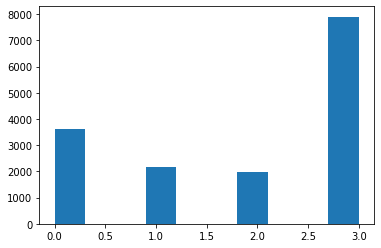

In [38]:
from collections import Counter
dist = Counter(y_train)
for k in dist:
    dist[k] /= len(y_train)
plt.hist(y_train)

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, pred)))

In [35]:
pred = tres(pred, t).astype(int)
# pred = treshold(pred, percent).astype(int)

# pred = format(pred, X_train, df_data, y_train).astype(int)

In [40]:
pred = final_pred

In [30]:
pred

array([1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 2,
       2, 0, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 0,
       2, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2,
       2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2,
       2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 0,
       2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 0, 1,
       0, 1, 2, 2, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 2, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 0, 2, 2,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 0, 1,
       2, 2, 1, 2, 1, 1, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0,
       2, 1, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1,
       1, 1, 1, 0, 2, 1, 1, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 0,
       2, 2, 0, 2, 1, 2, 0, 1, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2,
       2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0,

(array([231.,   0.,   0., 139.,   0.,   0., 127.,   0.,   0., 503.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

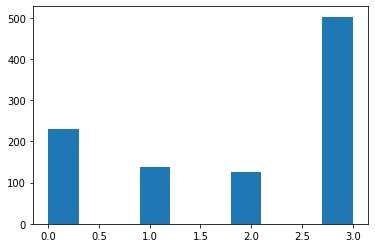

In [41]:
plt.hist(pred)

In [42]:
X = []
for i in range(len(pred)):
    X.append([ids[i], pred[i]])

In [43]:
pred = pd.DataFrame(X, columns = ['installation_id','accuracy_group'])

In [44]:
pred.index = pred['installation_id']

In [45]:
sample_sub = pd.read_csv(subs)
sample_sub['accuracy_group'] = pred.loc[sample_sub['installation_id'].values]['accuracy_group'].values

In [46]:
sample_sub.to_csv('submission1.csv', index = False)

In [47]:
sample_sub

,installation_id,accuracy_group
0,00abaee7,1
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2
...,...,...
995,fee254cf,3
996,ff57e602,0
997,ffc73fb2,1
998,ffe00ca8,1
